In [1]:
# NOTES

In [4]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [5]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
1,-0.258469,0.0,0.111111,0.0,0.66,4
2,0.303061,1.0,0.090909,0.0,0.66,3
3,0.905386,1.0,0.060000,0.0,0.40,3
6,0.298625,3.0,0.325581,2.0,1.00,14
7,2.561272,1.0,0.236842,1.0,1.00,9


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

roc_curve = RocCurveDisplay.from_estimator # shorthand

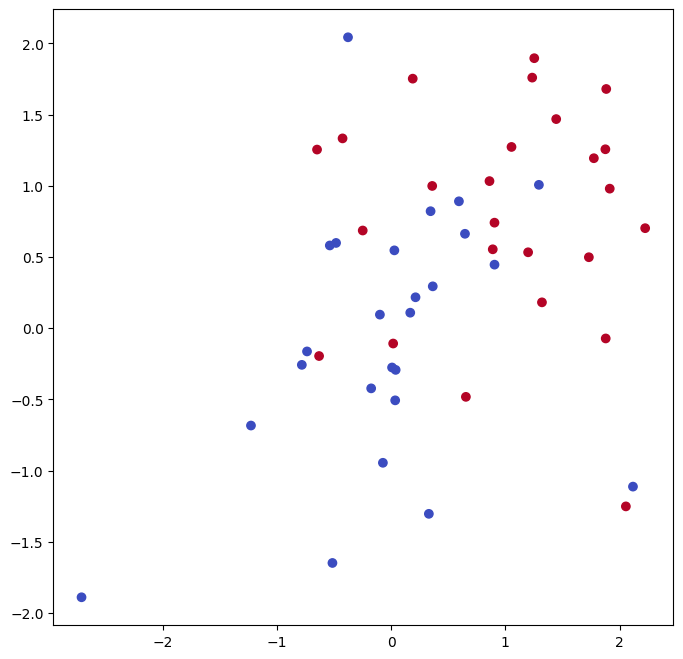

In [7]:
# Running a Support Vector Classifier on made up data
# Using 2 dimensions

rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap=plt.cm.coolwarm
)
plt.show()

In [9]:
# Data above is not linearly separable
# Now we fit the classifier

svm_linear = SVC(C=10, kernel="linear") # C is the width of the margin area for the support vectors
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

In [10]:
svm_linear_small = SVC(C=0.1, kernel="linear")
svm_linear_small.fit(X, y)
svm_linear.coef_


array([[1.17303943, 0.77348227]])

In [11]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    svm_linear,
    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
    refit=True,
    cv=5,
    scoring="accuracy"
)
grid.fit(X, y)
grid.best_params_

{'C': 1}

In [12]:
grid.cv_results_[("mean_test_score")]

array([0.66, 0.66, 0.72, 0.74, 0.74, 0.74, 0.74])

In [13]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1

best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_hat, y_test)

# Best estimator puts us at 70% accuracy

array([[8, 4],
       [2, 6]])

In [14]:
svm_ = SVC(C=0.001,kernel="linear").fit(X, y)
y_test_hat = svm_.predict(X_test)
confusion_matrix(y_test_hat, y_test)

# Worse result at 60% due to C=0.001 instead of C=1


array([[ 2,  0],
       [ 8, 10]])

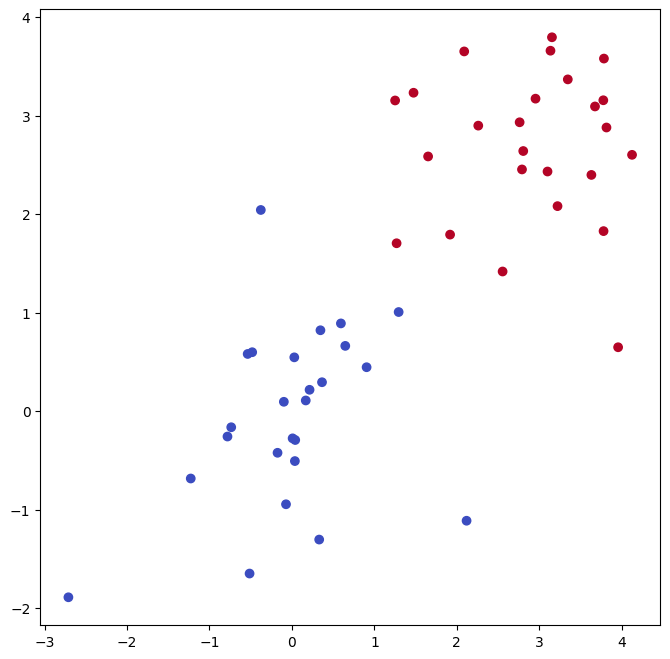

In [15]:
X[y==1] += 1.9
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.show()

In [16]:
svm_ = SVC(C=1e5, kernel="linear").fit(X, y)
y_hat = svm_.predict(X)
confusion_matrix(y_hat, y)

array([[25,  0],
       [ 0, 25]])

In [17]:
# In order to fit an SVM using a non-linear kernel, we once again use the
# SVC() estimator. However, now we use a different value of the parameter
# kernel. To fit an SVM with a polynomial kernel we use kernel="poly", and
# to fit an SVM with a radial kernel we use kernel="rbf". In the former case
# we also use the degree argument to specify a degree for the polynomial
# kernel (this is d in (9.22)), and in the latter case we use gamma to specify a
# value of γ for the radial basis kernel (9.24).

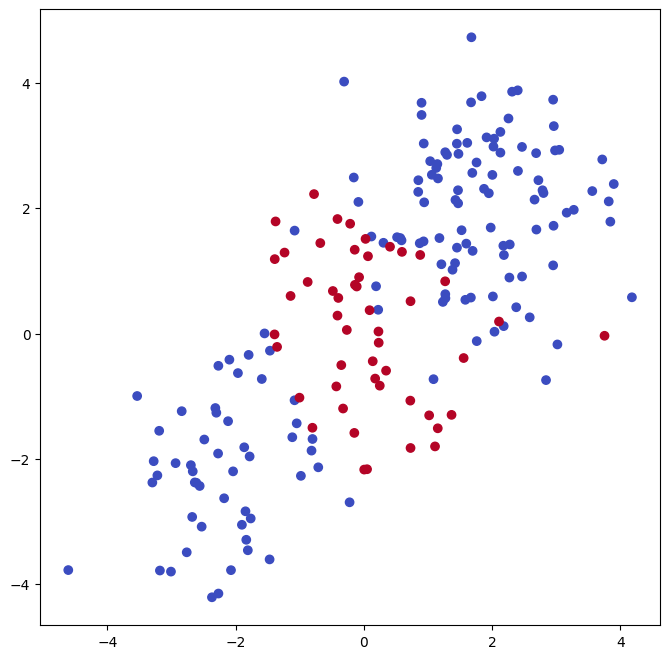

In [19]:
# SVMs when the support vector/margin can't be defined
# by a linear/straight line

X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap=plt.cm.coolwarm
)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1) # higher gamma is more wiggly
svm_rbf.fit(X_train, y_train)

SVC(C=1, gamma=1)

In [21]:
grid = GridSearchCV(
    svm_rbf,
    {"C": [0.1, 1, 10, 100, 1000],
     "gamma": [0.5, 1, 2, 3, 4]},
     refit=True,
     cv=5,
     scoring="accuracy"
)

grid.fit(X_train, y_train)
grid.best_params_

{'C': 100, 'gamma': 1}

In [22]:
best_svm = grid.best_estimator_
y_hat_test = best_svm.predict(X_test)
confusion_matrix(y_hat_test, y_test)

array([[70,  9],
       [ 5, 16]])

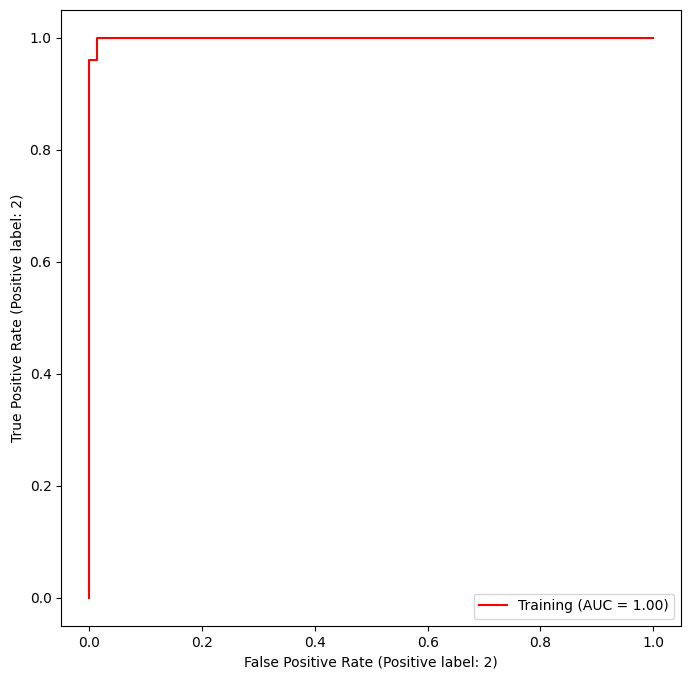

In [23]:
# ROC Curve on training data
fig, ax = plt.subplots(figsize=(8,8))
roc_curve(
    best_svm,
    X_train,
    y_train,
    name="Training",
    color="r",
    ax=ax
)

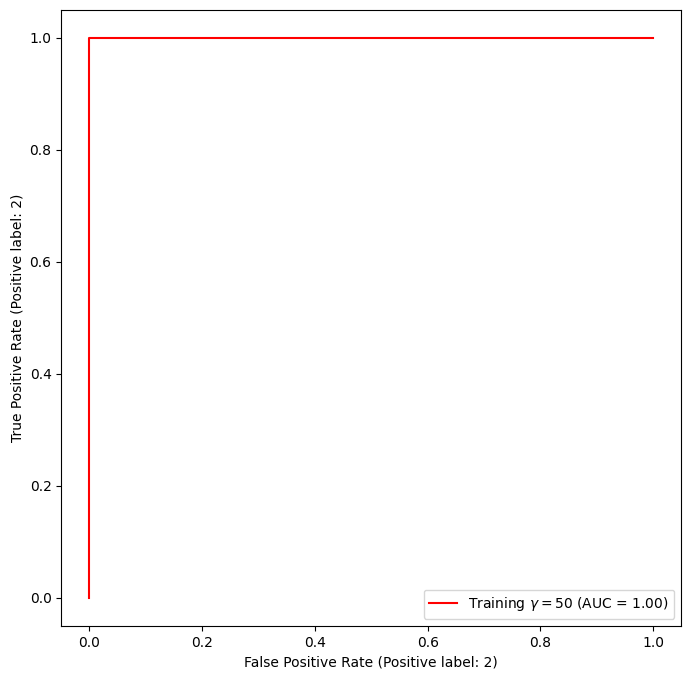

In [24]:
# Same but with gamma=50
svm_flex = SVC(kernel="rbf", gamma=50, C=1)
svm_flex.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(8,8))
roc_curve(
    svm_flex,
    X_train,
    y_train,
    name="Training $\gamma=50$",
    color="r",
    ax=ax
)
plt.show()

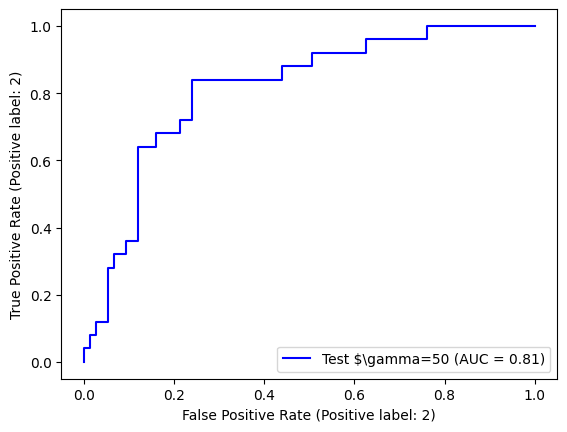

In [28]:
# ROC Curve on test data
fig, ax = plt.subplots()
roc_curve(
    svm_flex,
    X_test,
    y_test,
    name="Test $\gamma=50",
    color="b",
    ax=ax
)
plt.show()

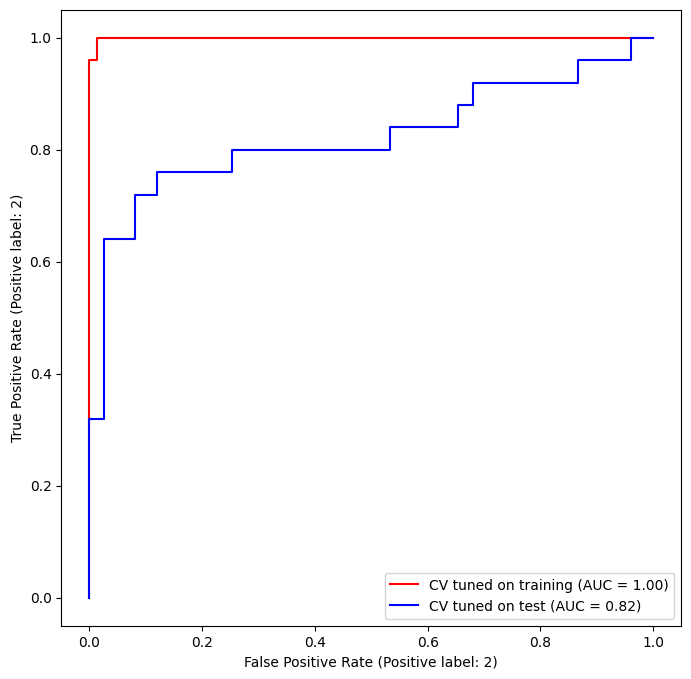

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
for X_, y_, c, name in zip(
    (X_train, X_test),
    (y_train, y_test),
    ("r", "b"),
    ("CV tuned on training",
     "CV tuned on test")
):
    roc_curve(
        best_svm,
        X_,
        y_,
        name=name,
        ax=ax,
        color=c
    )

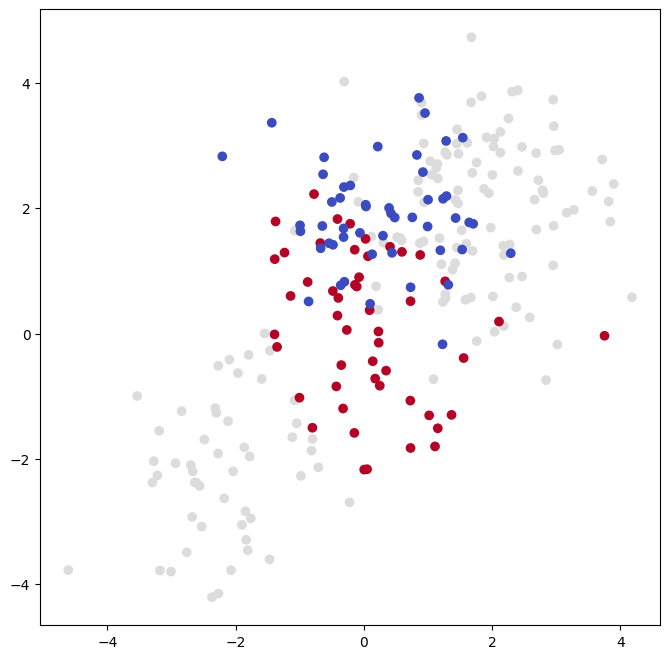

In [30]:
# SVM with multiple classes

rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50,2))])
y = np.hstack([y, [0]*50])
X[y==0, 1] += 2
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.show()

In [32]:
svm_rbf_3 = SVC(
    kernel="rbf",
    C=10,
    gamma=1,
    decision_function_shape="ovo"
) # one versus one aka isolating each class vs each other class individually

# the alternative is one versus all where the class is compared to all others at once
svm_rbf_3.fit(X, y)

SVC(C=10, decision_function_shape='ovo', gamma=1)

In [33]:
# I think if we are using multiple predictors, we would need to just run a grid search
# on all the different methods here to see which one is the best